## PCG

**PCG Classification using 1D convolutional neural network**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.utils import shuffle
import librosa as lb
from collections import Counter
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, AveragePooling1D, Dropout, Dense, Input
from tensorflow.keras.models import Model, Sequential
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load sound files as raw data
def load_data(data_dir, excel_file):
    data = [] # list of all raw audio array

    for i in range(excel_file.shape[0]): # loop to load all files with the given name mentioned in exel file
      aud = dir_wavfile+str(excel_file.iloc[i].values[0])+'.wav' #full path to heart wav file
      dt , sr = lb.load(aud, sr=8000) # dt : raw array and sr:sampling rate
      #print(aud)
      dt = lb.to_mono(dt) # convert to mono channel if it is double
      dt = dt.astype('float32')

      # resampling frequecy rate into fix 2000 
      number_of_samples = round(len(dt) * float(8000) / sr) # total samples in full signals
      readings_resampled = signal.resample(dt, number_of_samples) # resample signal into calculated samples so getting 2000 sr. 

      #b, a = signal.butter(4, [0.03,0.5], 'bandpass', analog=False) # 4rt order banpass butterworth filter
      #readings_filtered = signal.filtfilt(b, a, readings_resampled) # apply filter to signal

      data.append([readings_resampled, excel_file.iloc[i].values[1]]) # append each signal into list as raw audio data

    return np.array(data)

# make Chunks
def data_extension(data):
  data_ext = [] # extended/trimmed data list of 10 sec equal chunks 
  y = [] # list of labels normal/abnormal
  input_length = 8000*4 # 10 seconds

  for i in range(0, len(data)): # loop through evey raw audio array
    if len(data[i][0]) > input_length: # if signal len is greater then 10 sec
          for t in range(0, len(data[i][0])-input_length, input_length):
           temp = data[i][0][t:t + input_length]
           data_ext.append(temp)
           y.append(data[i][1])
           temp2 = data[i][0][len(temp):]
          if len(temp2)<input_length:# and len(temp2)>=4*2000:
            dx = temp2
            while (input_length>len(dx)):                                          # if signal len is less then 10 sec 
              dif = abs(input_length - len(dx))     # get require extended len 
              req_padd = dx[:dif]
              dx = np.append(dx, req_padd, axis=0)
              data_ext.append(dx)
              y.append(dd[i][1])
    
    
    else: 
      dx = data[i][0]
      while (input_length>len(dx)):                                          # if signal len is less then 10 sec 
        dif = abs(input_length - len(dx))     # get require extended len 
        req_padd = dx[:dif]
        dx = np.append(dx, req_padd, axis=0)
        # for s in req_padd:
        #   dx.append(s)
    
      #dx = np.pad(data[i][0], (0,dif), mode = 'constant') # append zeros at end of signal reading equal to require extended len
      data_ext.append(dx) # append extended/trimmed data to list
      y.append(data[i][1]) # append the label to label list

  return data_ext, y

# train_Val_test split
def split_data(test_size, validation_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [4]:
# geting data PCG sound samples
dir_wavfile = "/content/drive/MyDrive/FYP-Code/FYP-Final/Merged-Data/"
#excel_file = pd.read_excel(dir_wavfile+"Labels.xlsx", header=None)
excel_file = pd.read_excel("/content/drive/MyDrive/FYP-Code/FYP-Final/Labels.xlsx", header=None)
excel_file.dropna(inplace=True)
#excel_file = pd.read_csv("/content/drive/MyDrive/FYP-Code/Labels.txt", header=None)
excel_file.head()
raw_data= load_data(dir_wavfile, excel_file)

len(raw_data)

5532

In [5]:
# Preprocessing
X, y = data_extension(raw_data)
X = preprocessing.scale(X)
y[:] = [0 if i==-1 else i for i in y]

X, y = shuffle(X, y)
#print(y[0:25])
print("X_length:",len(X))
print("y_length:",len(y))

X = np.asarray(X)
y = np.asarray(y)
print("y_labels_count:",Counter(y))

X_length: 5532
y_length: 5532
y_labels_count: Counter({0: 3230, 1: 2302})


In [6]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = split_data(0.05, 0.1)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.12)
print("Train set:",X_train.shape)
print("Test set:",X_test.shape)
print("Validation set:",X_validation.shape)

Train set: (4729, 32000)
Test set: (277, 32000)
Validation set: (526, 32000)


In [7]:
# Reshaping data for 1D conv model
X_train = X_train.reshape(4729,8000,4) 
X_test = X_test.reshape(277,8000,4)
X_validation = X_validation.reshape(526,8000,4)
print("Train set:",X_train.shape)
print("Test set:",X_test.shape)
print("Validation set:",X_validation.shape)

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_validation = to_categorical(y_validation, 2)

Train set: (4729, 8000, 4)
Test set: (277, 8000, 4)
Validation set: (526, 8000, 4)


**1D Convolution Model**

In [8]:
def Conv_model(X_train):

    x_input = Input(shape =(X_train.shape[1], X_train.shape[2]))

    conv0 = Conv1D(512, kernel_size=3, activation='relu', padding='same')(x_input) #, kernel_regularizer=l2(0.001)
    D0=Dropout(0.25)(conv0)
    pool0 = MaxPooling1D(pool_size=2,padding='same')(D0)

    conv1 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(pool0)
    D1=Dropout(0.25)(conv1)
    pool1 = MaxPooling1D(pool_size=2,padding='same')(D1)

    conv2 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(pool1)
    D2=Dropout(0.25)(conv2)
    pool2 = MaxPooling1D(pool_size=2,padding='same')(D2)

    conv3 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    D3=Dropout(0.25)(conv3)
    pool3 = MaxPooling1D(pool_size=2,padding='same')(D3)

    conv4 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(pool3)
    D4=Dropout(0.25)(conv4)
    pool4 = MaxPooling1D(pool_size=2,padding='same')(D4)

    conv5 = Conv1D(16, kernel_size=3, activation='relu', padding='same')(pool4)
    D5=Dropout(0.25)(conv5)
    pool5 = MaxPooling1D(pool_size=2,padding='same')(D5)

    flat1 = Flatten()(pool5)
    #D6=Dropout(0.25)(flat1)

    output = Dense(2, activation = 'softmax')(flat1) #softmax
    model = Model(inputs=x_input, outputs=output)
    
    return model

In [ ]:
model = Conv_model(X_train)
#model.summary()
# compile model
optimiser = Adam(learning_rate=0.00001)
model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy'])
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='mini')
callbacks_list = [checkpoint]

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=4, epochs=150)
model.save(r'/content/conv_model1')
model.save(r'/content/conv_model1.h5')
model.save_weights(r'/content/model_weights1.h5')

Epoch 1/150
1183/1183 [==============================] - 47s 29ms/step - loss: 0.6882 - accuracy: 0.5509 - val_loss: 0.6805 - val_accuracy: 0.5856
Epoch 2/150
1183/1183 [==============================] - 34s 29ms/step - loss: 0.6683 - accuracy: 0.5910 - val_loss: 0.6661 - val_accuracy: 0.5875
Epoch 3/150
1183/1183 [==============================] - 34s 29ms/step - loss: 0.6291 - accuracy: 0.6376 - val_loss: 0.6330 - val_accuracy: 0.6331
Epoch 4/150
1183/1183 [==============================] - 34s 29ms/step - loss: 0.5697 - accuracy: 0.6953 - val_loss: 0.5845 - val_accuracy: 0.6787
Epoch 5/150
1183/1183 [==============================] - 35s 29ms/step - loss: 0.5149 - accuracy: 0.7355 - val_loss: 0.5519 - val_accuracy: 0.6882
Epoch 6/150
1183/1183 [==============================] - 35s 29ms/step - loss: 0.4846 - accuracy: 0.7456 - val_loss: 0.5256 - val_accuracy: 0.7148
Epoch 7/150
1183/1183 [==============================] - 35s 29ms/step - loss: 0.4593 - accuracy: 0.7619 - val_loss: 0

**Performance**

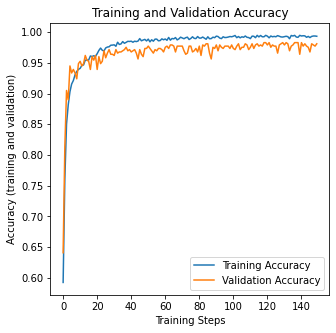

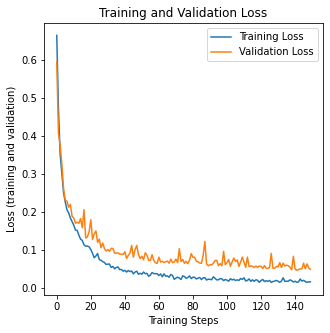

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(150)

#plt.subplot(2, 2, 1)
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/train_val_accuracy.png')
plt.show()
#plt.subplot(2, 2, 2)
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/train_val_loss.png')
plt.show()

In [11]:
def evaluation_metrics(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred) * 100, 2)
    precision = round(precision_score(y_true, y_pred,average='weighted') * 100, 2)
    f1Score = round(f1_score(y_true, y_pred, average='weighted') * 100, 2) 
    target_names=['Abnormal','Normal']
    cm=confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fp = cm[0][1]
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv= tp / (tp+fp)
    npr= tn / (tn+fn)

    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    print("\nconfusion_matrix")
    print(cm)
    print("\nTrue Negative  : {}".format(tn))
    print("Flase Positive  : {}".format(fp))
    print("False Negative  : {}".format(fn))
    print("True Positive  : {}".format(tp))
    print("\nSpecificity  : {}".format(specificity))
    print("Sensitivity  : {}".format(sensitivity))
    print("Positive predictive value (PPV): {}".format(ppv))
    print("Negative predictive value (NPV)  : {}".format(npr))
  
    return accuracy, precision, f1Score, cm

In [12]:
# Validation
validation_data_cnn = (X_validation, y_validation)
predictions_cnn_validation = model.predict(X_validation, verbose=1)
yPredictions_cnn_validation = np.argmax(predictions_cnn_validation, axis=1)
true_classes_cnn_validation=np.argmax(y_validation, axis=1)
print("Validation data:")    
valAcc, valPrec, valFScore,valcm = evaluation_metrics(true_classes_cnn_validation, yPredictions_cnn_validation)

17/17 [==============================] - 2s 65ms/step
Validation data:
Accuracy  : 98.1
Precision : 98.13
f1Score : 98.1

confusion_matrix
[[302   8]
 [  2 214]]

True Negative  : 302
Flase Positive  : 8
False Negative  : 2
True Positive  : 214

Specificity  : 0.9741935483870968
Sensitivity  : 0.9907407407407407
Positive predictive value (PPV): 0.963963963963964
Negative predictive value (NPV)  : 0.993421052631579


In [13]:
# Real Test Data
test_data_cnn = (X_test, y_test)
predictions_cnn_test = model.predict(X_test, verbose=1)
yPredictions_cnn_test = np.argmax(predictions_cnn_test, axis=1)
true_classes_cnn_test=np.argmax(y_test, axis=1)
print("Real test data:")    
valAcc, valPrec, valFScore,valcm = evaluation_metrics(true_classes_cnn_test, yPredictions_cnn_test)

9/9 [==============================] - 1s 98ms/step
Real test data:
Accuracy  : 98.56
Precision : 98.56
f1Score : 98.56

confusion_matrix
[[159   2]
 [  2 114]]

True Negative  : 159
Flase Positive  : 2
False Negative  : 2
True Positive  : 114

Specificity  : 0.9875776397515528
Sensitivity  : 0.9827586206896551
Positive predictive value (PPV): 0.9827586206896551
Negative predictive value (NPV)  : 0.9875776397515528


**Test on a single audio**

In [30]:
#aud = "/content/Normal sounds_744-20211118101046-19–33-Male-Normal.wav"
aud = "/content/AD1625296193763.wav"
dt , sr = lb.load(aud, sr=8000) # dt : raw array and sr:sampling rate
dt = lb.to_mono(dt) # convert to mono channel if it is double
dt = dt.astype('float32')

# resampling frequecy rate into fix 2000 
number_of_samples = round(len(dt) * float(8000) / sr) # total samples in full signals
aud_resampled = signal.resample(dt, number_of_samples) # resample signal into calculated samples so getting 2000 sr. 

# b, a = signal.butter(4, [0.03,0.5], 'bandpass', analog=False) # 4rt order banpass butterworth filter
# aud_filtered = signal.filtfilt(b, a, aud_resampled) # apply filter to signal

aud_filtered = aud_resampled

input_length = 8000*4 # 10 seconds
if len(aud_filtered) > input_length: # if audio len is greater then 10 sec
  max_offset = len(aud_filtered) - input_length   # max limit 
  offset = np.random.randint(max_offset)   # get a random position in the signal upto max limit
  aud_final = aud_filtered[offset:(input_length+offset)]  # get signal readings upto 10 sec 
else:                                           # if signal len is less then 10 sec 
  dif = abs(input_length - len(aud_filtered))     # get require extended len 
  aud_final = np.pad(aud_filtered, (0,dif), mode = 'constant') # append zeros at end of signal reading equal to require extended len

import soundfile as sf
sf.write('processed_audio2.wav', aud_final, 8000)

In [31]:
aud = "/content/AD1625296193763.wav"
dt , sr = lb.load(aud, sr=8000) # dt : raw array and sr:sampling rate
print("Total_samples:",len(dt))
print("Sampling rate:",sr)
print("Audio Duration:",len(dt)/sr)
print("Shape", dt.shape)
#print("Reshape for Model",dt.reshape(1,2000,10).shape)

Total_samples: 48320
Sampling rate: 8000
Audio Duration: 6.04
Shape (48320,)


In [32]:
import tensorflow as tf
aud = "/content/processed_audio2.wav"
dd,s=lb.load(aud,sr=8000)
dd = dd.reshape(1,8000,4)
model = tf.keras.models.load_model("/content/conv_model1.h5")
classes_prob = model.predict(dd)
classes_prob

array([[0.78178763, 0.2182124 ]], dtype=float32)

In [34]:
class1 = model.predict(dd)
   print("Probability",class1)
  classes=np.argmax(class1)
  
  if classes == 0:
    print('aud "{}" Detected Normal'.format(aud))
  else:
    print('aud "{}" Detected Abromal'.format(aud))
  print()


IndentationError: ignored

In [ ]:
total_prob = classes[0][0]+classes[0][1]
total_prob

NameError: ignored

In [ ]:
# Convert the model
import tensorflow as tf
from keras.models import load_model
model = tf.keras.models.load_model(r"/content/conv_model1")
converter = converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()


# Save the model
with open('pcg.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkgqdfiml/assets


INFO:tensorflow:Assets written to: /tmp/tmpkgqdfiml/assets
